<center>
<div style="color:;
           display:fill;
           border-radius:5px;
           background-color: lightgray;
           font-size:110%;
           letter-spacing:0.5px">

<h2 style="padding: 10px;
              color:white;">Dog breed identification
</h2>
</div>

1. [Introduction](#introduction)
1. [Data Collection](#datacollection)
1. [Data Analysis](#dataanalysis)
    1. [Explore Labels](#explorelabels)
    1. [Explore Images](#exploreimages)
    1. [Data Visualization](#datavisualization)
1. [Data Preprocessing](#datapreprocessing)
    1. [Data Augmentation](#dpdataaugmentation)
    1. [Labels encoding](#labelsencoding)
    1. [Create Dataset](#createdataset)
1. [Model Training and Evaluation](#trainandevaluate)
    1. [Search best models](#searchbestmodels)
    1. [Stacking classifier](#stackingclassifier)
1. [Submission](#submission)
1. [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>

In this notebook, for the task of dog breed identification, I will try to evaluate different prelearned models from <a href="https://keras.io/api/applications/">Keras Applications</a> and <a href="https://pypi.org/project/vit-keras/">Keras implementation of ViT (Vision Transformer)</a>, and then build a stacking classifier from the best of them. It is also interesting to check how well models based on CNNs perform compared to Vision Transformer.

Vision Transformer is a very interesting architecture for image classification that uses a Transformer-like architecture over patches of the image. I will not cover this architecture in my notebook (there are a lot of resources in web described this topic), I will only check its performance for this classification task.

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning, UserWarning))

import time
import os
import numpy as np
import pandas as pd
import math
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import itertools
from itertools import islice
import tensorflow as tf
import keras_tuner as kt
import keras
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, MaxPooling2D, GlobalAvgPool2D, Input, concatenate, Average, RandomZoom, RandomTranslation, Rescaling, Concatenate, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD, Adam, Nadam, RMSprop
from keras.utils import to_categorical, plot_model
from keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from keras.metrics import categorical_accuracy
from keras.applications import Xception, ResNet50, ResNet101, InceptionV3, InceptionResNetV2, MobileNet, DenseNet121, DenseNet201, NASNetMobile, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5
from IPython.display import Markdown, display
from sklearn.preprocessing import LabelEncoder

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

IMAGE_SIZE = (448, 448)
BATCH_SIZE = 32

def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")

In [2]:
!pip install --quiet vit-keras
from vit_keras import vit
from vit_keras import visualize

## Data Collection <a class="anchor" id="datacollection"></a>

In [3]:
competition = "dog-breed-identification"
if not ON_KAGGLE:
    download_from_kaggle(competition)
    labels_path = "labels.csv"
    submission_path = "sample_submission.csv"
else:
    labels_path = f"/kaggle/input/{competition}/labels.csv"
    submission_path = f"/kaggle/input/{competition}/sample_submission.csv"
    
labels_df = pd.read_csv(labels_path)
submission_df = pd.read_csv(submission_path)

In [4]:
train_folder = f"/kaggle/input/{competition}/train/"
test_folder = f"/kaggle/input/{competition}/test/"
train_folder, test_folder

('/kaggle/input/dog-breed-identification/train/',
 '/kaggle/input/dog-breed-identification/test/')

# Data Analysis <a class="anchor" id="dataanalysis"></a>

## Explore Labels <a class="anchor" id="explorelabels"></a>

In [5]:
print(f'Labels shape:\t {labels_df.shape}',
     f'\nSubmission shape:\t {submission_df.shape}')

Labels shape:	 (10222, 2) 
Submission shape:	 (10357, 121)


In [6]:
labels_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [7]:
submission_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.008333      0.008333   
1  00102ee9d8eb90812350685311fe5890       0.008333      0.008333   
2  0012a730dfa437f5f3613fb75efcd4ce       0.008333      0.008333   
3  001510bc8570bbeee98c8d80c8a95ec1       0.008333      0.008333   
4  001a5f3114548acdefa3d4da05474c2e       0.008333      0.008333   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.008333  0.008333                        0.008333     0.008333   
1             0.008333  0.008333                        0.008333     0.008333   
2             0.008333  0.008333                        0.008333     0.008333   
3             0.008333  0.008333                        0.008333     0.008333   
4             0.008333  0.008333                        0.008333     0.008333   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
1            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
2            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
3            0.008333  0.008333  0.008333  ...    0.008333     0.008333   
4            0.008333  0.008333  0.008333  ...    0.008333     0.008333   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.008333      0.008333    0.008333                0.008333   
1  0.008333      0.008333    0.008333                0.008333   
2  0.008333      0.008333    0.008333                0.008333   
3  0.008333      0.008333    0.008333                0.008333   
4  0.008333      0.008333    0.008333                0.008333   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.008333  0.008333                 0.008333   
1                     0.008333  0.008333                 0.008333   
2                     0.008333  0.008333                 0.008333   
3                     0.008333  0.008333                 0.008333   
4                     0.008333  0.008333                 0.008333   

   yorkshire_terrier  
0           0.008333  
1           0.008333  
2           0.008333  
3           0.008333  
4           0.008333  

[5 rows x 121 columns]

## Explore images <a class="anchor" id="exploreimages"></a>

In [8]:
def get_images_info(folder):
    size_images = dict()
    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            file_path = os.path.join(folder, file_name)
            with Image.open(file_path) as img:
                width, heigth = img.size
                resolution = width*heigth
                root_resolution = math.sqrt(resolution)
                ratioHW = heigth / width
                size_images[file_name] = {'width': width, 'heigth': heigth, 'resolution': resolution, 
                                          'root_resolution': root_resolution, 'ratioHW': ratioHW}
    return size_images

Evaluate image sizes. This information is useful for selecting image sizes for model learning.

In [9]:
images_info_dict = get_images_info(train_folder)
images_info_pd = pd.DataFrame.from_dict(images_info_dict, orient='index')
images_info_pd.head()

width  heigth  resolution  \
7d9c53fa846ea7e34bc3efa6830ab668.jpg    250     198       49500   
04e3bb77c15c18fc1ac101d86d612f46.jpg    500     375      187500   
2de892b241aeab50aad28c319eaebdbd.jpg    333     500      166500   
bca88d42e4fc84b3169b13a615f5fdbf.jpg    500     375      187500   
6496959bd5a27de3cb15e771ca2ae7b3.jpg    411     500      205500   

                                      root_resolution   ratioHW  
7d9c53fa846ea7e34bc3efa6830ab668.jpg       222.485955  0.792000  
04e3bb77c15c18fc1ac101d86d612f46.jpg       433.012702  0.750000  
2de892b241aeab50aad28c319eaebdbd.jpg       408.044115  1.501502  
bca88d42e4fc84b3169b13a615f5fdbf.jpg       433.012702  0.750000  
6496959bd5a27de3cb15e771ca2ae7b3.jpg       453.321078  1.216545

In [10]:
images_info_pd.describe()

width        heigth    resolution  root_resolution       ratioHW
count  10222.00000  10222.000000  1.022200e+04     10222.000000  10222.000000
mean     443.33154    386.747212  1.841763e+05       410.013726      0.913662
std      152.42012    130.068327  2.303240e+05       126.754338      0.287223
min       97.00000    102.000000  1.224000e+04       110.634533      0.384000
25%      360.00000    333.000000  1.650000e+05       406.201920      0.748000
50%      500.00000    375.000000  1.838750e+05       428.806458      0.750000
75%      500.00000    452.000000  1.875000e+05       433.012702      1.079914
max     3264.00000   2562.000000  7.990272e+06      2826.706918      2.540816

### Data Visualization <a class="anchor" id="datavisualization"></a>

In [11]:
def plot_image_from_path(image_path, label):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)
    plt.show()

Plot random image.

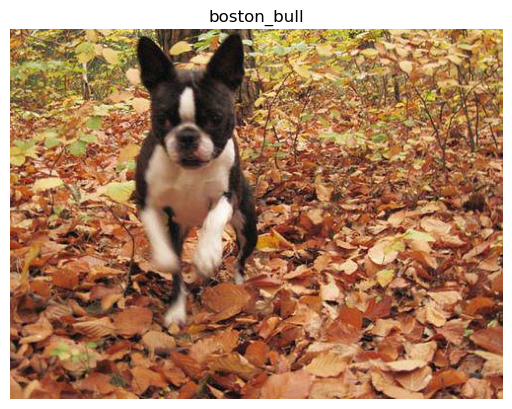

In [12]:
image_item = labels_df.iloc[0]
path_to_image = os.path.join(train_folder, f"{image_item.id}.jpg")
plot_image_from_path(path_to_image, image_item.breed)

# Data Preprocessing <a class="anchor" id="datapreprocessing"></a>

### Data augmentation <a class="anchor" id="dpdataaugmentation"></a>

Create a data augmentation block for further use in the learning process.

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.05),
    RandomZoom(0.1),
], name='data_augmentation')

### Labels encoding <a class="anchor" id="labelsencoding"></a>

Encode breeds with a value between 0 and 119 using sklearn.preprocessing.LabelEncoder and then convert these values to one-hot encoding.

In [14]:
labels_df['label'] = LabelEncoder().fit_transform(labels_df.breed)
labels_df.head()

id             breed  label
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull     19
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo     37
2  001cdf01b096e06d78e9e5112d419397          pekinese     85
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick     15
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever     49

In [15]:
labels_list = labels_df['label'].to_numpy().tolist()

In [16]:
y_full_oh = tf.keras.utils.to_categorical(labels_list, num_classes=120, dtype='float32')
y_full_oh[:1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Create an additional dictionary for identifying breed labels from numeric values.

In [17]:
labels_breeds_df = labels_df[['label','breed']].copy()
labels_breeds_df.drop_duplicates(inplace=True)
labels_breeds_df.set_index('label',drop=True,inplace=True)
index_to_breed = labels_breeds_df.to_dict()['breed']
list(islice(index_to_breed.items(), 10))

[(19, 'boston_bull'),
 (37, 'dingo'),
 (85, 'pekinese'),
 (15, 'bluetick'),
 (49, 'golden_retriever'),
 (10, 'bedlington_terrier'),
 (18, 'borzoi'),
 (7, 'basenji'),
 (97, 'scottish_deerhound'),
 (99, 'shetland_sheepdog')]

Complete list of all breeds in the dataset.

In [18]:
dog_breeds = sorted(list(index_to_breed.values()))
dog_breeds[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [19]:
len(dog_breeds)

120

### Create Dataset <a class="anchor" id="createdataset"></a>

Create functions for creating tf.data.Dataset. These functions will be used below in the Model Training section to create datasets with different parameters. To create datasets, I use image_dataset_from_directory function. I also tried from_tensor_slices function with additional image loading and preprocessing functions (including resize_with_pad and CenterCrop), but without better results.

In [20]:
def prepare_ds(ds, prep_input_fx, cache_ds=False, shuffle=False, batch_size=32, prefetch=True):
    ds_has_y = isinstance(ds.element_spec, tuple)
    if ds_has_y:
        ds = ds.map(lambda x, y: (prep_input_fx(x), y))
    else:
        ds = ds.map(lambda x: prep_input_fx(x))
    if cache_ds:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(128)
    ds = ds.batch(batch_size)
    if prefetch:
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [21]:
def create_raw_ds(train_folder, labels_list, split_size=0.1, image_size=(224,224)):
    train_ds_raw, val_ds_raw = tf.keras.utils.image_dataset_from_directory(
        train_folder,
#         seed=SEED,
        labels=labels_list,
        label_mode='categorical',
        validation_split=0.1,
        shuffle=False,
        subset="both",
        image_size=image_size,
        batch_size=None,
        crop_to_aspect_ratio=False
    )
    return train_ds_raw, val_ds_raw

Create final datasets for training after using the Keras tuner.

In [22]:
train_ds_raw, val_ds_raw = create_raw_ds(train_folder, labels_list, image_size=IMAGE_SIZE)

Found 10222 files belonging to 120 classes.
Using 9200 files for training.
Using 1022 files for validation.


In [23]:
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    labels=None,
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=None,
    crop_to_aspect_ratio=False
)

Found 10357 files belonging to 1 classes.


I do not use the .cache function here because it is very memory consuming and can quickly overflow all RAM with large enough image sizes.

In [24]:
train_ds = train_ds_raw.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds_raw.batch(BATCH_SIZE)
test_ds = test_ds_raw.batch(BATCH_SIZE)
train_ds.element_spec, val_ds.element_spec, test_ds.element_spec

((TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None))

#### Data Visualization

Review and visualize images in the created dataset.

In [25]:
def plot_ds_images(ds):
    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        lbl=labels.numpy()
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(index_to_breed[lbl[i].argmax()])
            plt.axis("off")

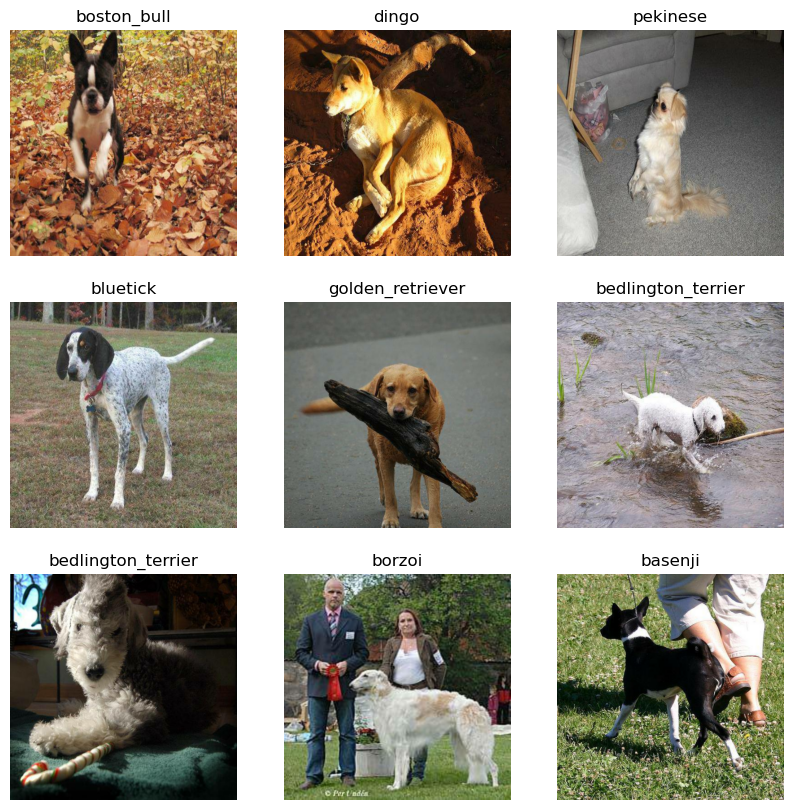

In [26]:
plot_ds_images(train_ds)

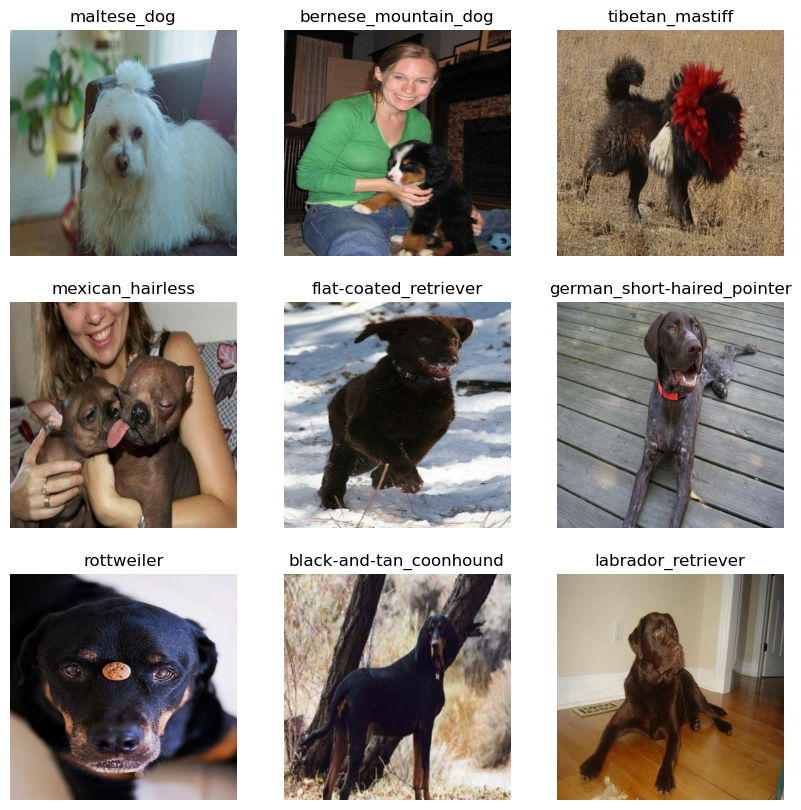

In [27]:
plot_ds_images(val_ds)

Visualize the attention map from the Vision Transformer model.

In [28]:
def plot_attention_map(original_image, attention_image):
    fig, (ax1, ax2) = plt.subplots(ncols = 2)
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(original_image)
    _ = ax2.imshow(attention_image)

In [29]:
vit_model_test = vit.vit_b32(
    image_size = IMAGE_SIZE,
    activation = 'softmax',
    pretrained = True,
    include_top = True,
    pretrained_top = False,
    classes = 120
)

353253686/353253686 [==============================] - 7s 0us/step


1/1 [==============================] - 6s 6s/step


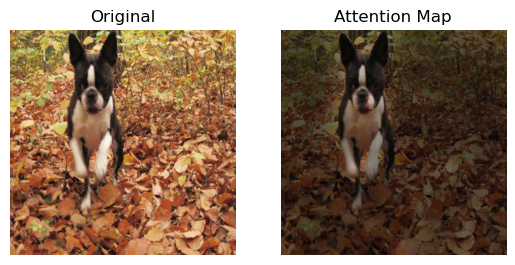

In [30]:
for image, _ in train_ds_raw.take(1):
    image_example = image.numpy().astype('uint8')
    break
attention_map = visualize.attention_map(model = vit_model_test, image = image_example)
plot_attention_map(image_example, attention_map)

In [31]:
del vit_model_test
gc.collect()

20035

# Model Training and Evaluation <a class="anchor" id="trainandevaluate"></a>

In [32]:
early_stopping = EarlyStopping(
    monitor='val_categorical_accuracy', 
    patience=10,
    verbose=1,
    restore_best_weights = True)
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_categorical_accuracy', 
    patience=3, verbose=1, factor=0.3
)

In [33]:
def grid_search_report(grid_search, res_num=10):
    tuner_report_df = pd.DataFrame()
    trials = grid_search.oracle.get_best_trials(num_trials=15)
    for trial in trials:
        tuner_report_df = tuner_report_df.append(
            trial.hyperparameters.get_config()["values"] | {"Score": trial.score}, 
            ignore_index=True)
    display(tuner_report_df.head(res_num))

In [34]:
def get_loss_and_acc(y_true, y_pred):
    cat_ce = tf.keras.losses.CategoricalCrossentropy()
    loss_value = cat_ce(y_true, y_pred).numpy()
    cat_acc = tf.keras.metrics.CategoricalAccuracy()
    cat_acc.update_state(y_true, y_pred)
    acc_value = cat_acc.result().numpy()
    return [loss_value, acc_value]

## Search best models <a class="anchor" id="searchbestmodels"></a>

Let's evaluate different pre-trained models from official Keras applications and Keras implementation of ViT (Vision Transformer) using Keras GridSearch tuner.

In model search I use not very big image size and only part of images in training dataset. It's not so crusial because main goal of this section is to compare performance of models and to choose best ones (of course it can be something different on full set and other image sizes).

Each application will be created without top layers (added manually), with pre-trained weights on imagenet dataset. All base model layers are frozen (used transfer learning). For other hyperparameters like learning rate, optimizer and so on I chose standart  values.

In [35]:
IMAGE_SIZE_search = (288, 288)

Create a helper dictionary for use in the Keras tuner for building appropriate models and preprocessing images. Keys of the dictionary are model names, values are model classes and preprocessing functions.

In [36]:
models_search = {
    'vit_l32': [vit.vit_l32, vit.preprocess_inputs],
    'EfficientNetB4': [EfficientNetB4, keras.applications.efficientnet.preprocess_input],
    'InceptionResNetV2': [InceptionResNetV2, keras.applications.inception_resnet_v2.preprocess_input],
    'MobileNetV2': [MobileNet, keras.applications.mobilenet.preprocess_input],
    'Xception': [Xception, keras.applications.xception.preprocess_input],
    'DenseNet201': [DenseNet201, keras.applications.densenet.preprocess_input],
 }

Create functions for building models in Keras Tuner.

In [37]:
def get_keras_model(app_class, shape, base_locked=True, learning_rate=0.001):
    base_model = app_class(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
    )
    inputs = keras.Input(shape=shape)
    aug_inputs = data_augmentation(inputs)
    x = base_model(aug_inputs)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
    outputs = Dense(120, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    base_model.trainable = not base_locked
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=categorical_crossentropy, 
              optimizer=optimizer,
              metrics=[categorical_accuracy]
             )
    return model

In [38]:
def get_vit_model(app_class, shape, base_locked=True, learning_rate=0.001):
    base_model = app_class(
        image_size = shape[:2],
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 120
    )
    inputs = keras.Input(shape=shape)
    aug_inputs = data_augmentation(inputs)
    x = base_model(aug_inputs)
    x = Dropout(0.7)(x)
    outputs = Dense(120, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    base_model.trainable = not base_locked
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=categorical_crossentropy, 
              optimizer=optimizer,
              metrics=[categorical_accuracy]
             )
    return model

Create main builder function.

In [39]:
def model_app_builder(hp):
    models_names = list(models_search.keys())
    model_type = hp.Choice('model_type', values=models_names)
    model_class = models_search[model_type][0]
    if model_type.startswith('vit'):
        model = get_vit_model(model_class, IMAGE_SIZE_search + (3,))
    else:
        model = get_keras_model(model_class, IMAGE_SIZE_search + (3,))
    return model

I create a subclass of GridSearch with redefined "run_trial" method, because for each model I need slightly different datasets with own processing function.

In [40]:
class CustomGridTuner(kt.tuners.GridSearch):
    def run_trial(self, trial, train_ds, *args, **kwargs):
        val_ds = kwargs['validation_data']
        hp = trial.hyperparameters
        model_type = hp.Choice('model_type', values = list(models_search.keys()))
        prep_input = models_search[model_type][1]
        train_ds = prepare_ds(train_ds, prep_input)
        val_ds = prepare_ds(val_ds, prep_input, prefetch=False)
        kwargs['validation_data'] = val_ds
        return super(CustomGridTuner, self).run_trial(trial, train_ds, *args, **kwargs)

Create training and validation datasets with relatively small image sizes.

In [41]:
train_ds_raw, val_ds_raw = create_raw_ds(train_folder, labels_list, image_size=IMAGE_SIZE_search)

Found 10222 files belonging to 120 classes.
Using 9200 files for training.
Using 1022 files for validation.


In [42]:
train_ds_raw.element_spec, val_ds_raw.element_spec

((TensorSpec(shape=(288, 288, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(120,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(288, 288, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(120,), dtype=tf.float32, name=None)))

Specify only the part of the training dataset to be used in the Keras tuner to speed up the grid search.

In [43]:
train_ratio_search = 0.4
train_len = int(train_ds_raw.cardinality())
train_len_search = int(round(train_len * train_ratio_search, 0))
print(f'Searhing ds length: {train_len_search}')

Searhing ds length: 3680


Create a CustomGridTuner object and start searching.

In [44]:
grid_search_tuner = CustomGridTuner(
    hypermodel=model_app_builder,
    objective="val_categorical_accuracy",
    seed=42,
    overwrite=True
)
grid_search_tuner.search(
    train_ds_raw.take(train_len_search),
    validation_data=val_ds_raw,
    epochs=10,
)

Trial 6 Complete [00h 03m 49s]
val_categorical_accuracy: 0.8679060935974121

Best val_categorical_accuracy So Far: 0.9559686779975891
Total elapsed time: 00h 27m 46s


In [45]:
grid_search_report(grid_search_tuner, 14)

model_type     Score
0            vit_l32  0.955969
1  InceptionResNetV2  0.926614
2     EfficientNetB4  0.923679
3           Xception  0.894325
4        DenseNet201  0.867906
5        MobileNetV2  0.734834

As we see, Vision Transformer Large models are best, some of Keras applications also has good performance.

In [46]:
gc.collect()

2989

## Stacking classifier <a class="anchor" id="stackingclassifier"></a>

Select some best models for further stacking and training.

I use here only transfer learning without fine-tuning (I also tried it, but without better results). Therefore I use here technique for feature extraction from base stacking model (without top classifier layer) and pass them for training top MLP model (again not only NN but other models like logistic regression can be used). This approach also reduces the training time.

In [47]:
models_for_stacking = ['vit_l32', 'EfficientNetB4', 'InceptionResNetV2']

In [48]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=False):
        return super().call(inputs, training=True)

In [49]:
def get_keras_model_feat(app_class, shape, inputs, prep_input_fx):
    base_model = app_class(
        include_top=False,
        weights='imagenet',
        input_shape=shape,
    )
    x = prep_input_fx(inputs)
    x = base_model(x)
    outputs = keras.layers.GlobalAveragePooling2D()(x)
    return outputs

In [50]:
def get_vit_model_feat(app_class, shape, inputs, prep_input_fx):
    base_model = app_class(
        image_size = shape[:2],
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 120
    )    
    x = prep_input_fx(inputs)
    outputs = base_model(x)
    return outputs

In [51]:
def build_feat_model(models_names, shape, aug_layer=None):
    all_outputs = []
    inputs = keras.Input(shape=shape)
    if aug_layer != None:
        aug_inputs = aug_layer(inputs)
    else:
        aug_inputs = inputs
    for model_type in models_names:
        model_class = models_search[model_type][0]
        model_prep_input = models_search[model_type][1]
        if model_type.startswith('vit'):
            model_outputs = get_vit_model_feat(model_class, shape, aug_inputs, model_prep_input)
        else:
            model_outputs = get_keras_model_feat(model_class, shape, aug_inputs, model_prep_input)
        all_outputs.append(model_outputs)
    concat_outputs = Concatenate()(all_outputs)
    model = Model(inputs, concat_outputs)
    return model

In [52]:
model_features = build_feat_model(models_for_stacking, IMAGE_SIZE + (3,), data_augmentation)
model_features.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, None, None,   0          ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 448, 448, 3)  0          ['data_augmentation[7][0]']      
                                                                                            

In [53]:
def get_features_from_model(model, ds, count=1):
    features = []
    ds_has_y = isinstance(ds.element_spec, tuple)
    if ds_has_y:
        labels = []
        y = np.concatenate([y for x, y in ds], axis=0)
    for i in range(count):
        predictions = model.predict(ds)
        features.append(predictions)
        if ds_has_y:
            labels.append(y)
    if ds_has_y:
        return np.concatenate(features), np.concatenate(labels)
    else:
        return np.concatenate(features)

With param count we can multiply dataset and each count will get slightly different features because of using data augmentation layer.

In [54]:
features_train, y_train = get_features_from_model(model_features, train_ds, count=2)
features_val, y_val = get_features_from_model(model_features, val_ds)
print(features_train.shape, y_train.shape, features_val.shape, y_val.shape)

32/32 [==============================] - 49s 2s/step
(18400, 4352) (18400, 120) (1022, 4352) (1022, 120)


After extracting features from the base model, create Dense top model and train it on those features. I use MCDropout here instead of regular dropout. It allows to slightly increase the performance on the test dataset.

In [55]:
dnn_model = keras.models.Sequential([
    Input(features_train.shape[1:]),
    MCDropout(0.7),
    Dense(120, activation='softmax')
])

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy, TopKCategoricalAccuracy

def precision_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    true_positives = tf.reduce_sum(tf.cast(y_true == y_pred, 'float32'))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, 'float32'))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall_m(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    true_positives = tf.reduce_sum(tf.cast(y_true == y_pred, 'float32'))
    possible_positives = tf.reduce_sum(tf.cast(y_true, 'float32'))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [56]:
# Compile the model
dnn_model.compile(
    optimizer=Adam(0.0001),
    loss=categorical_crossentropy,
    metrics=["categorical_accuracy"]
)

In [57]:
history_dnn = dnn_model.fit(
    features_train, 
    y_train,
    validation_data=(features_val, y_val),
    batch_size=128,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)

Epoch 1/50
144/144 [==============================] - 1s 4ms/step - loss: 3.2881 - categorical_accuracy: 0.3635 - val_loss: 1.6930 - val_categorical_accuracy: 0.7779 - lr: 1.0000e-04
Epoch 2/50
144/144 [==============================] - 0s 3ms/step - loss: 0.9611 - categorical_accuracy: 0.8918 - val_loss: 0.5663 - val_categorical_accuracy: 0.9266 - lr: 1.0000e-04
Epoch 3/50
144/144 [==============================] - 0s 3ms/step - loss: 0.4160 - categorical_accuracy: 0.9389 - val_loss: 0.3366 - val_categorical_accuracy: 0.9432 - lr: 1.0000e-04
Epoch 4/50
144/144 [==============================] - 0s 3ms/step - loss: 0.2745 - categorical_accuracy: 0.9482 - val_loss: 0.2505 - val_categorical_accuracy: 0.9579 - lr: 1.0000e-04
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.2109 - categorical_accuracy: 0.9595 - val_loss: 0.2213 - val_categorical_accuracy: 0.9521 - lr: 1.0000e-04
Epoch 6/50
144/144 [==============================] - 1s 4ms/step - loss: 0.1791 - ca

In [58]:
y_val_probas = np.stack([dnn_model.predict(features_val)
                     for sample in range(50)])
val_predictions = y_val_probas.mean(axis=0)

32/32 [==============================] - 0s 1ms/step


In [59]:
val_loss, val_accuracy = get_loss_and_acc(y_val, val_predictions)
print(f"Validation loss: {val_loss}",
     f"\nValidation accuracy: {round(val_accuracy*100, 3)}")

Validation loss: 0.11556435376405716 
Validation accuracy: 96.967


In [60]:
gc.collect()

34061

# Submission <a class="anchor" id="submission"></a>

In [61]:
features_test = get_features_from_model(model_features, test_ds)
features_test.shape

324/324 [==============================] - 473s 1s/step


(10357, 4352)

In [62]:
y_probas = np.stack([dnn_model.predict(features_test)
                     for sample in range(100)])
predictions = y_probas.mean(axis=0)

324/324 [==============================] - 1s 2ms/step


In [63]:
submission_df.loc[:, dog_breeds] = predictions
submission_df.head()

id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e       0.000011      0.000012   
1  00102ee9d8eb90812350685311fe5890       0.000007      0.000004   
2  0012a730dfa437f5f3613fb75efcd4ce       0.000006      0.000053   
3  001510bc8570bbeee98c8d80c8a95ec1       0.000050      0.000002   
4  001a5f3114548acdefa3d4da05474c2e       0.002431      0.000275   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.000004  0.000009                        0.000007     0.000008   
1             0.000002  0.000015                        0.000020     0.000015   
2             0.000070  0.000023                        0.000012     0.000041   
3             0.000001  0.000004                        0.000001     0.000024   
4             0.000108  0.000052                        0.000107     0.000113   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.000008  0.000002  0.000004  ...    0.000026     0.000008   
1            0.000012  0.000028  0.000003  ...    0.000017     0.000021   
2            0.000011  0.000005  0.000058  ...    0.000008     0.000022   
3            0.000007  0.000006  0.000006  ...    0.000096     0.000004   
4            0.001136  0.000078  0.000109  ...    0.000202     0.000185   

     vizsla  walker_hound  weimaraner  welsh_springer_spaniel  \
0  0.000017      0.000008    0.000003            3.290517e-06   
1  0.000013      0.000017    0.000003            2.442426e-06   
2  0.000071      0.000026    0.000074            1.394725e-04   
3  0.000007      0.000009    0.000003            8.703664e-07   
4  0.000037      0.000120    0.000042            3.624973e-05   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.000014  0.000003                 0.000012   
1                     0.000060  0.000004                 0.000010   
2                     0.000028  0.000027                 0.000032   
3                     0.000003  0.000009                 0.000002   
4                     0.000117  0.000136                 0.000926   

   yorkshire_terrier  
0           0.000009  
1           0.000004  
2           0.000017  
3           0.000013  
4           0.000440  

[5 rows x 121 columns]

In [64]:
submission_df.to_csv('submission.csv', index=False)

# Conclusion <a class="anchor" id="conclusion"></a>

Comparison of CNN and ViT models showed that the latter (large versions with patch equal to 32) get better performance (I also tested them on full dataset with different image sizes). Staking the models allowed to increase the individual scores. The achieved loss is not very low (compared to the top leaderboard positions with losses of 0 and little more), but good enough.

In [65]:
# Sequence of models and number of epochs per model
models_sequence = [
    'Xception', 'InceptionResNetV2', 'MobileNetV2', 
    'DenseNet201', 'EfficientNetB4', 'vit_l32'
]

model_indices = {model: models_sequence.index(model) for model in models_for_stacking}
model_indices

{'vit_l32': 5, 'EfficientNetB4': 4, 'InceptionResNetV2': 1}

Epoch 1/700
144/144 [==============================] - 1s 4ms/step - loss: 0.0649 - categorical_accuracy: 0.9815 - val_loss: 0.1386 - val_categorical_accuracy: 0.9609 - lr: 2.4300e-07
Epoch 2/700
144/144 [==============================] - 0s 3ms/step - loss: 0.0650 - categorical_accuracy: 0.9811 - val_loss: 0.1289 - val_categorical_accuracy: 0.9628 - lr: 2.4300e-07
Epoch 3/700
144/144 [==============================] - 0s 3ms/step - loss: 0.0649 - categorical_accuracy: 0.9817 - val_loss: 0.1413 - val_categorical_accuracy: 0.9618 - lr: 2.4300e-07
Epoch 4/700
144/144 [==============================] - 0s 3ms/step - loss: 0.0646 - categorical_accuracy: 0.9821 - val_loss: 0.1399 - val_categorical_accuracy: 0.9618 - lr: 2.4300e-07
Epoch 5/700
137/144 [===========================>..] - ETA: 0s - loss: 0.0637 - categorical_accuracy: 0.9823
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.289999643944612e-08.
144/144 [==============================] - 0s 3ms/step - loss: 0.0636 - categor

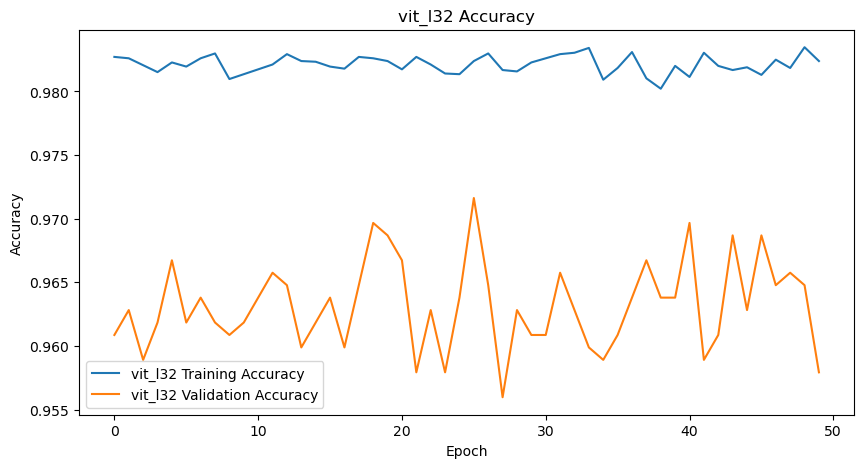

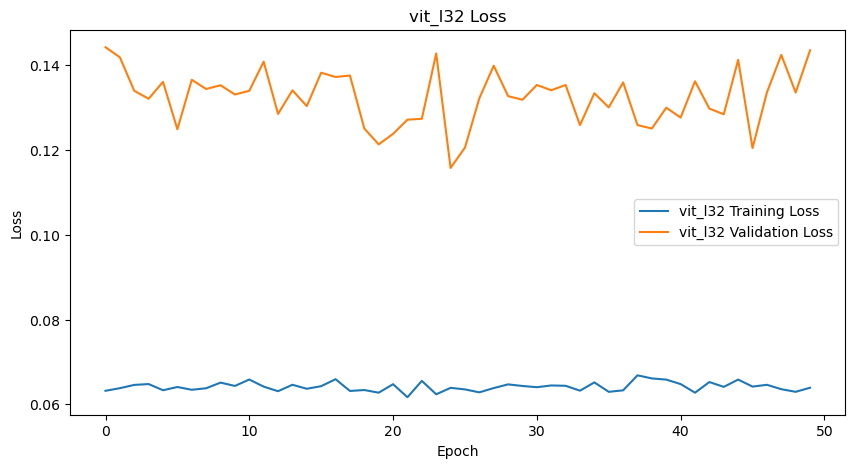

Extracting history for EfficientNetB4 from epoch 200 to 250


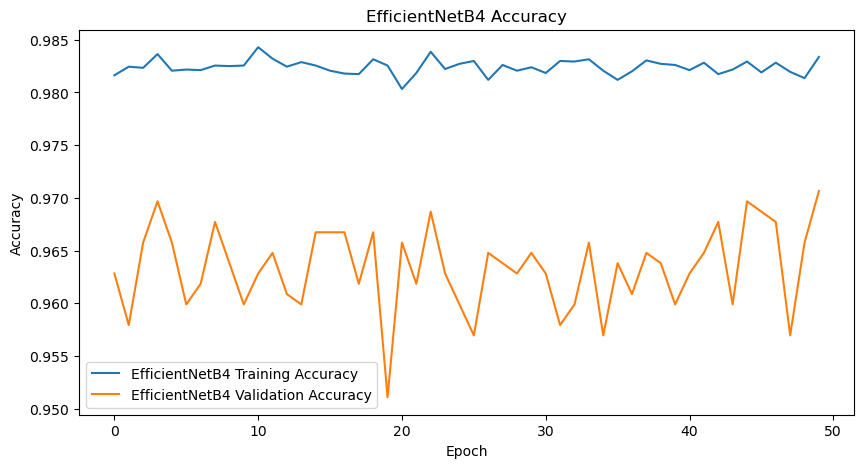

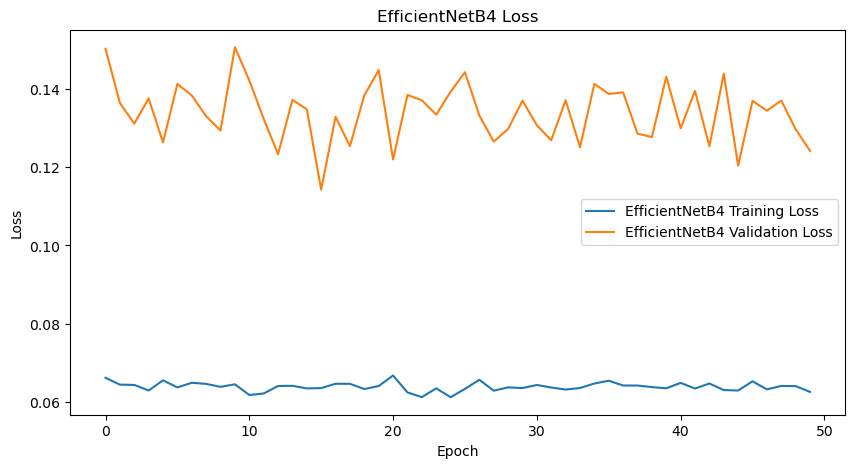

Extracting history for InceptionResNetV2 from epoch 50 to 100


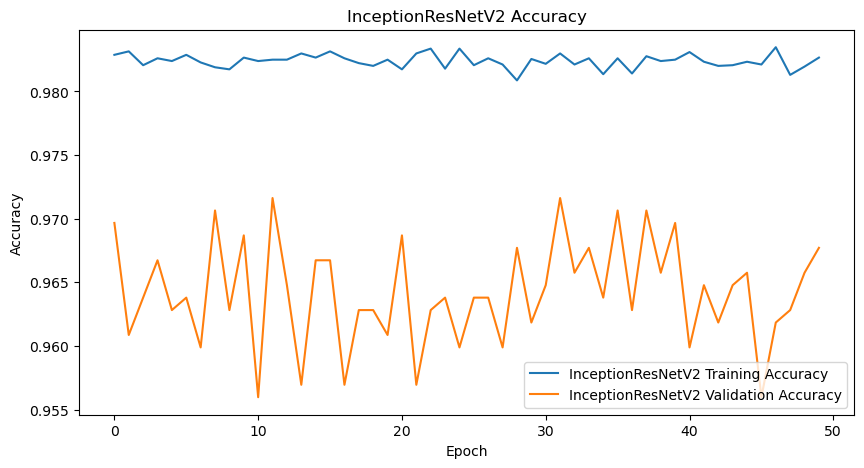

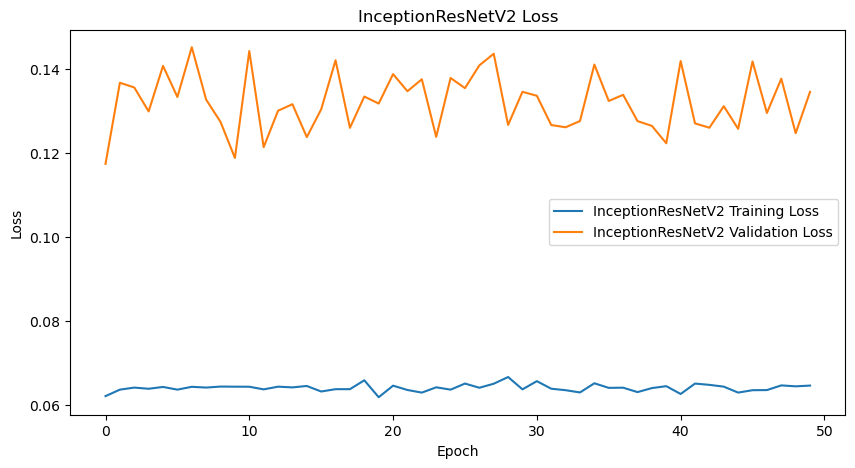

In [66]:
# Train the model without early stopping
history_dnn = dnn_model.fit(
    features_train, 
    y_train,
    validation_data=(features_val, y_val),
    batch_size=128,
    epochs=700,  # Total epochs for all models combined (14 models * 50 epochs each)
    callbacks=[reduce_lr_on_plateau]  # Removed early_stopping callback
)

# Sequence of models and number of epochs per model
models_sequence = [
    'Xception', 'InceptionResNetV2', 'MobileNetV2', 
    'DenseNet201', 'EfficientNetB4', 'vit_l32'
]
epochs_per_model = 50

# Determine indices for the required models
required_models = ['vit_l32', 'EfficientNetB4', 'InceptionResNetV2']
model_indices = {model: models_sequence.index(model) for model in required_models}

# Extract data for each required model
def extract_history(history_dnn, model_indices, model_name):
    start = model_indices[model_name] * epochs_per_model
    end = (model_indices[model_name] + 1) * epochs_per_model
    print(f"Extracting history for {model_name} from epoch {start} to {end}")
    return {
        'categorical_accuracy': history_dnn.history['categorical_accuracy'][start:end],
        'val_categorical_accuracy': history_dnn.history['val_categorical_accuracy'][start:end],
        'loss': history_dnn.history['loss'][start:end],
        'val_loss': history_dnn.history['val_loss'][start:end]
    }

# Plot the history for each required model
def plot_model_history(history, model_name):
    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history['categorical_accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history['val_categorical_accuracy'], label=f'{model_name} Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history['val_loss'], label=f'{model_name} Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Extract and plot history for each required model
for model in required_models:
    history = extract_history(history_dnn, model_indices, model)
    plot_model_history(history, model)

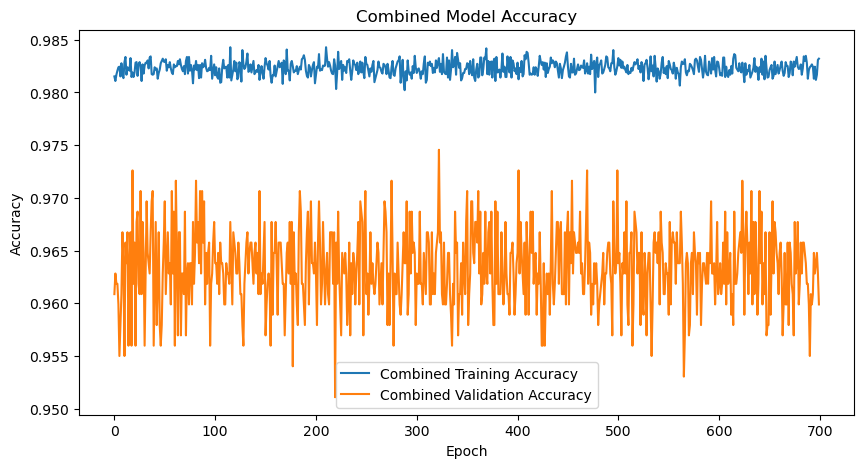

In [67]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_dnn.history['categorical_accuracy'], label='Combined Training Accuracy')
plt.plot(history_dnn.history['val_categorical_accuracy'], label='Combined Validation Accuracy')
plt.title('Combined Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

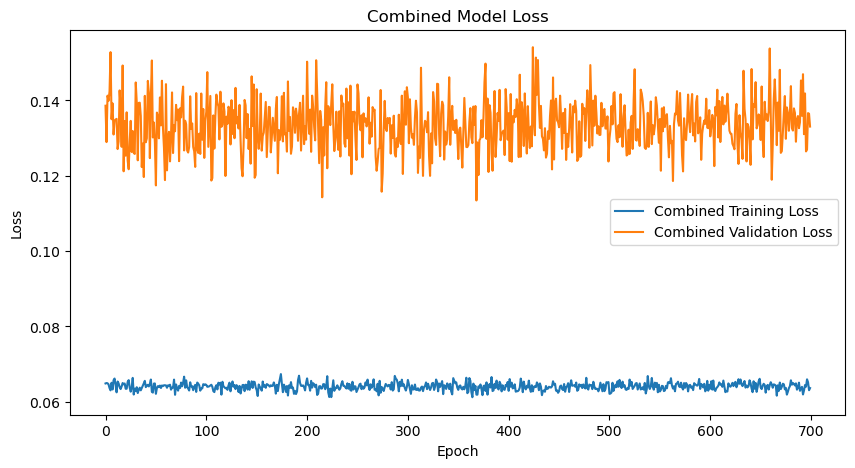

In [68]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_dnn.history['loss'], label='Combined Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Combined Validation Loss')
plt.title('Combined Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()